In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 2"

from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC, LinearSVC, SVC
import numpy as np
import pandas as pd
import math
import pickle
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random
import cv2
from tqdm import tqdm
from collections import Counter
import utils
from datasets import *
from models import *
import albumentations as A
from albumentations.pytorch import ToTensorV2

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
def crop(im, r, c, target_r, target_c):
	return im[r:target_r, c:target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    # get shape of the image
    r,c,*_ = im.shape
    # pick the minimum size to use to create the square crop
    min_sz = min(r,c)
    # calculate start row/column values using minimum size
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

(320, 320, 3)

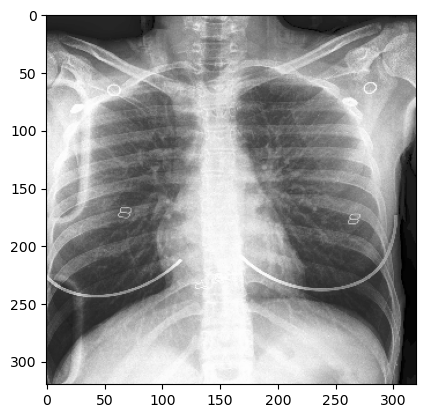

In [3]:
pth = '/home/cwbennie/data/chexpert_xrays/CheXpert_v1.0_train/patient07172/study1/view1_frontal.jpg'
im = get_a_crop(pth, 320)
plt.imshow(im)
im.shape

In [10]:
def resize_all_images(path: Path, output_path: Path, target_size=320):
    os.makedirs(output_path, exist_ok=True)
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            if file.endswith('jpg'):
                im_file = os.path.join(dirpath, file)
                try:
                    img = cv2.resize(cv2.imread(im_file), (target_size, target_size))
                    rel_path = os.path.relpath(dirpath, path)
                    target_dir = os.path.join(output_path, rel_path)
                    os.makedirs(target_dir, exist_ok=True)
                    output_file = os.path.join(target_dir, file)
                    cv2.imwrite(str(output_file), img)
                except Exception as e:
                    print(f'Empty image: {e}')

In [11]:
chex_pth = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_v1.0_train')
resize_pth = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_320_train')
resize_all_images(chex_pth, resize_pth)

In [13]:
chex_pth = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_v1.0_validation')
resize_pth = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_320_valid')
resize_all_images(chex_pth, resize_pth)

In [16]:
def get_chexpert_labels(path: Path, dataframe: pd.DataFrame,
						data_type: str = 'train'):
	file_name = str(path).split('/')[6:]
	file_name = '/'.join(file_name)
	full_id = f'CheXpert-v1.0/{data_type}/' + file_name
	return torch.Tensor(list(map(int, list(dataframe.loc[full_id].values)[4:])))

In [27]:
def get_chexpert_images(path: Path, label_csv: str,
                        data_type: str = 'train',
                        uncertainty_type: str = 'own_class'):
    images = list()
    label_info = pd.read_csv(label_csv)
    label_info.fillna(0.0, inplace=True)
    if uncertainty_type == 'own_class':
        label_info.replace(-1, 2, inplace=True)
    elif uncertainty_type == 'pos_replace':
        label_info.replace(-1, 1, inplace=True)
    else:
        label_info.replace(-1, 0, inplace=True)
    label_info.set_index('Path', inplace=True)
    labels = list()
    for dirpath, dirnames, files in os.walk(Path(path)):
        for file in files:
            if file.endswith('jpg'):
                im_file = os.path.join(dirpath, file)
                images.append(im_file)
                label = get_chexpert_labels(im_file, label_info, data_type)
                labels.append(label)
    return images, labels

In [9]:
def transform_image(image, transform_pipe: A.Compose):
    img = cv2.imread(str(image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = transform_pipe(image=img)
    return augmented['image']

In [10]:
class CheXpertData(Dataset):
    def __init__(self, dir_path: Path, label_csv: Path,
                 transform: bool = False, data_type: str = 'train',
                 uncertainty_type: str = 'own_class'):
        self.image_dir = dir_path
        self.label_csv = label_csv
        self.data_type = data_type
        self.images, self.labels = get_chexpert_images(path=self.image_dir,
                                                       label_csv=label_csv,
                                                       data_type=self.data_type,
                                                       uncertainty_type=uncertainty_type)
        if transform:
            self.transforms = A.Compose([
                A.Resize(320, 320),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=30),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2()
                ])
        else:
            self.transforms = A.Compose([
                A.Resize(320, 320),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2()
                ])
    
    def __len__(self):
        return len(self.labels)
   
    def __getitem__(self, index):
        image = self.images[index]
        image_arr = utils.transform_image(image, self.transforms)
        return image_arr, self.labels[index]

In [66]:
chex_dir = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_v1.0_train')
train_csv = '/home/cwbennie/data/chexpert_xrays/chexpert_csv_files/train.csv'

chex_data = CheXpertData(chex_dir, train_csv, transform=True, uncertainty_type='pos_class')
tst_data = CheXpertData(chex_dir, train_csv, transform=True, uncertainty_type='own_class')

Dataset size: 1000 images
Dataset size: 1000 images


In [17]:
valid_dir = Path('/home/cwbennie/data/chexpert_xrays/CheXpert_v1.0_validation')
val_csv = '/home/cwbennie/data/chexpert_xrays/chexpert_csv_files/valid.csv'

val_data = CheXpertData(valid_dir, val_csv, transform=False, data_type='valid',
						uncertainty_type='pos_class')

Dataset size: 234 images


In [20]:
class ChexNet(nn.Module):
    def __init__(self, output=14, binary=False,
                 labels_per_class=3):
        super(ChexNet, self).__init__()

        self.labels_pc = labels_per_class
        self.binary = binary
        self.classes = output

        densenet = models.densenet121(weights='DEFAULT')
        layers = list(densenet.children())[0]
        self.base_densenet = nn.Sequential(*layers)
        if self.binary:
            self.fc = nn.Linear(1024, self.classes)
        else:
            self.fc = nn.Linear(1024, self.classes * self.labels_pc)
    
    def forward(self, x):
        img = torch.relu(self.base_densenet(x))
        img = nn.AdaptiveAvgPool2d((1, 1))(img)
        img = img.view(img.size(0), -1)
        img = self.fc(img)
        if not self.binary:
            img = img.view(-1, self.classes, self.labels_pc)
        else:
            img = img.view(-1, self.classes)
        return img

In [21]:
def ave_auc(probs, ys):
    aucs = list()
    for i in range(probs.shape[1]):
        try:
            aucs.append(roc_auc_score(ys[:, i], probs[:, i]))
        except ValueError as e:
            print(f'Error: {e}')
    # aucs = [roc_auc_score(ys[:, i, :], probs[:, i, :], multi_class='ovr') for i in range(probs.shape[1])]
    return np.mean(aucs), aucs

In [22]:
def cuda2cpu_classification(y: torch.Tensor): return y.long().cpu().numpy()


def cuda2cpu_regression(y: torch.Tensor): return y.cpu().numpy()

In [23]:
def validate_loop(model: nn.Module, valid_dl: DataLoader, task: str):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if task=='binary':
        cuda2cpu = cuda2cpu_classification
        loss_fun = nn.BCEWithLogitsLoss()
    elif task == 'multilabel':
        cuda2cpu = cuda2cpu_classification
        loss_fun = nn.CrossEntropyLoss()
    elif task=='regression':
        cuda2cpu = cuda2cpu_regression
        loss_fun = F.l1_loss

    model.eval()
    total = 0
    sum_loss = 0
    ys = []
    preds = []

    for x, y in valid_dl:
        out = model(x.to(device))
        y = y.to(device)
        loss = loss_fun(out, y)
        ys.append(cuda2cpu(y))
        
        batch = y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch

        preds.append(out.detach().cpu().numpy())
        
    return sum_loss/total, preds, ys


def validate_multilabel(model, valid_dl, task: str = 'binary'):
    loss, preds, ys = validate_loop(model, valid_dl, task)

    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    # preds = np.vstack(preds)
    # ys = np.vstack(ys)
    mean_auc, aucs = ave_auc(preds, ys) if len(np.unique(ys)) > 1 else None
    # mean_auc, aucs = ave_auc(preds, ys)
    # try:
        
    # except ValueError as e:
    #     print(f'Error: {e}')
    #     return None
    return loss, mean_auc, None
    # return loss, mean_auc, aucs


def multilabel_loss(criterion: nn.Module, out: torch.Tensor, y: torch.Tensor):
	"""
	Function to calculate Cross Entropy Loss across multiple labels
	for multi-class models.
	"""
	if out.dim() > 2:
		out = out.view(-1, out.size(-1))
	if y.dim() > 1:
		y = y.view(-1)

	loss = criterion(out, y.long())
	return loss

In [25]:
def train_chex_model(model: nn.Module, optimizer: torch.optim.Adam,
                     train_dl: DataLoader, valid_dl: DataLoader,
                     epochs: int = 25, track_loss=False,
                     lr_scheduler=None,
                     criterion=nn.CrossEntropyLoss(),
                     **kwargs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optimizer(parameters, lr=0.0001, betas=(0.9, 0.999))
    if lr_scheduler is not None:
        scheduler = get_scheduler(name=lr_scheduler, optimizer=optimizer,
                                  epochs=epochs, **kwargs)
    epoch_losses = list()
    auc_scores = list()
    val_losses = list()

    # train the model for the given number of epochs
    for ep in range(epochs):
        losses = list()
        model.train()
        for i, (img, y) in enumerate(train_dl):
            img = img.to(device).float()
            y = y.to(device)
            out = model(img)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        epoch_losses.append(np.mean(losses))
        print(f'Epoch finished: Loss -> {np.mean(losses)}')
        if valid_dl:
            val_loss, epoch_auc, _ = validate_multilabel(model, valid_dl)
            val_losses.append(val_loss)
            auc_scores.append(epoch_auc)
            print(f'''Epoch Validation: Loss -> {val_loss}\n
                  AUC Score -> {epoch_auc}\n''')
        if lr_scheduler is not None:
            scheduler.step()
    if track_loss:
        return epoch_losses, val_losses

In [29]:
train_dl = DataLoader(chex_data, batch_size=40, shuffle=True)
val_dl = DataLoader(val_data, batch_size=8, shuffle=False)

In [67]:
multinet = ChexNet(output=14, binary=False, labels_per_class=3)

In [71]:
multi_dl = DataLoader(tst_data, batch_size=40, shuffle=True)

In [30]:
tst_mod = ChexNet(labels_per_class=2, binary=True)

In [31]:
train_chex_model(tst_mod, optimizer=torch.optim.Adam,
                 train_dl=train_dl, valid_dl=val_dl,
                 epochs=5, labels_per_class=2,
				 criterion=nn.BCEWithLogitsLoss())

Epoch finished: Loss -> 0.5522860407829284
Error: Only one class present in y_true. ROC AUC score is not defined in that case.
Epoch Validation: Loss -> 0.5025836692916023

                  AUC Score -> (0.6511155830686353, [0.8084049409237379, 0.6444770642201835, 0.6580439404677534, 0.7408877131099353, 0.8068669527896996, 0.7482657260435038, 0.555857078245138, 0.5398230088495575, 0.637987012987013, 0.4480088495575222, 0.7776387523460541, 0.37339055793991416, 0.7248509824122451])

Epoch finished: Loss -> 0.3658056116104126
Error: Only one class present in y_true. ROC AUC score is not defined in that case.
Epoch Validation: Loss -> 0.43566636346344256

                  AUC Score -> (0.6407476048135184, [0.8250537056928036, 0.6742752293577982, 0.6717753366406805, 0.8145208700764256, 0.3562231759656652, 0.7845972957084068, 0.6318407960199005, 0.47732300884955753, 0.676866883116883, 0.4043141592920354, 0.7984627759406561, 0.4849785407725322, 0.7294870851423946])

Epoch finished: Loss -> 

In [ ]:
del tst_mod

In [88]:
validate_multilabel(tst_mod, val_dl)

Probs shape: (234, 14, 3)
Ys shape: (234, 14, 3)
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 

/home/cwbennie/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cwbennie/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(11.986646798940805, nan, [])

In [ ]:
import torch.distributed as dist

def setup(rank, world_size):
	# set up to use NCCL backend
	os.environ['MASTER_ADDR'] = 'localhost'
	os.environ['MASTER_PORT'] = '12355'
	dist.init_process_group('nccl', rank=rank, world_size=world_size)

def cleanup():
	dist.destroy_process_group()
from torch.nn.parallel import DistributedDataParallel as DDP

def model_setup(model: nn.Module, dataset: Dataset,
				batch_sz: int, rank, world_size):
	model = model.to(rank)
	ddp_model = DDP(model, device_ids=[rank])

	# assume dataset is evenly divisible by world_size
	sampler = torch.utils.data.distributed.DistributedSampler(
		dataset, num_replicas=world_size, rank=rank)

	dist_dataloader = DataLoader(dataset, batch_size=batch_sz,
							  sampler=sampler)

	return ddp_model, dist_dataloader

In [16]:
import torch.distributed as dist

def setup(rank, world_size):
	# set up to use NCCL backend
	os.environ['MASTER_ADDR'] = 'localhost'
	os.environ['MASTER_PORT'] = '12355'
	dist.init_process_group('nccl', rank=rank, world_size=world_size)

def cleanup():
	dist.destroy_process_group()

In [ ]:
from torch.nn.parallel import DistributedDataParallel as DDP

def model_setup(model: nn.Module, dataset: Dataset,
				batch_sz: int, rank, world_size):
	model = model.to(rank)
	ddp_model = DDP(model, device_ids=[rank])

	# assume dataset is evenly divisible by world_size
	sampler = torch.utils.data.distributed.DistributedSampler(
		dataset, num_replicas=world_size, rank=rank)

	dist_dataloader = DataLoader(dataset, batch_size=batch_sz,
							  sampler=sampler)

	return ddp_model, dist_dataloader

In [ ]:
def train_chex_model_dist(model: nn.Module, optimizer: torch.optim.Adam,
                     train_dl: DataLoader, valid_dl: DataLoader,
                     rank, world_size,
                     epochs: int = 25, track_loss=False,
                     lr_scheduler=None,
                     criterion: torch.nn.Module = F.binary_cross_entropy_with_logits,
                     **kwargs):
    setup(rank, world_size)
    device = torch.device('cuda', rank)
    model = model.to(device)
    model = DDP(model, device_ids=[rank])
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optimizer(parameters, lr=0.0001, betas=(0.9, 0.999))
    if lr_scheduler is not None:
        scheduler = get_scheduler(name=lr_scheduler, optimizer=optimizer,
                                  epochs=epochs, **kwargs)
    epoch_losses = list()
    auc_scores = list()
    val_losses = list()
    # criterion = criterion.to(device)

    # train the model for the given number of epochs
    for ep in range(epochs):
        train_dl.sampler.set_epoch(ep)
        losses = list()
        model.train()
        for i, (img, y) in enumerate(train_dl):
            img = img.to(device).float()
            y = torch.stack(y, dim=1).to(device).float()
            out = model(img)
            loss = criterion(out.squeeze(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i % 1000 == 0 and rank == 0:
                print(f'Finished {i+1} iterations')
        epoch_losses.append(np.mean(losses))
        print(f'Epoch finished: Loss -> {np.mean(losses)}')
        if valid_dl and rank == 0:
            val_loss, epoch_auc, _ = validate_multilabel(model, valid_dl)
            val_losses.append(val_loss)
            auc_scores.append(epoch_auc)
            print(f'''Epoch Validation: Loss -> {val_loss}\n
                  AUC Score -> {epoch_auc}\n''')
        if lr_scheduler is not None:
            scheduler.step()

    cleanup()

    if track_loss and rank == 0:
        return epoch_losses, val_losses